---

_You are currently looking at **version 1.1** of this notebook. To download notebooks and datafiles, as well as get help on Jupyter notebooks in the Coursera platform, visit the [Jupyter Notebook FAQ](https://www.coursera.org/learn/python-data-analysis/resources/0dhYG) course resource._

---

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind

# Hypothesis Testing - Did the recession affect housing prices differently in university towns?

Definitions:
* A _quarter_ is a specific three month period, Q1 is January through March, Q2 is April through June, Q3 is July through September, Q4 is October through December.
* A _recession_ is defined as starting with two consecutive quarters of GDP decline, and ending with two consecutive quarters of GDP growth.
* A _recession bottom_ is the quarter within a recession which had the lowest GDP.
* A _university town_ is a city which has a high percentage of university students compared to the total population of the city.

**Hypothesis**: University towns have their mean housing prices less effected by recessions. Run a t-test to compare the ratio of the mean price of houses in university towns the quarter before the recession starts compared to the recession bottom. (`price_ratio=quarter_before_recession/recession_bottom`)

The following data files are used:
* From the [Zillow research data site](http://www.zillow.com/research/data/) there is housing data for the United States. In particular the datafile for [all homes at a city level](http://files.zillowstatic.com/research/public/City/City_Zhvi_AllHomes.csv), ```City_Zhvi_AllHomes.csv```, has median home sale prices at a fine grained level.
* From the Wikipedia page on college towns is a list of [university towns in the United States](https://en.wikipedia.org/wiki/List_of_college_towns#College_towns_in_the_United_States) which has been copy and pasted into the file ```university_towns.txt```.
* From Bureau of Economic Analysis, US Department of Commerce, the [GDP over time](http://www.bea.gov/national/index.htm#gdp) of the United States in current dollars (use the chained value in 2009 dollars), in quarterly intervals, in the file ```gdplev.xls```. For this assignment, only look at GDP data from the first quarter of 2000 onward.

In [2]:
# Use this dictionary to map state names to two letter acronyms
states = {'OH': 'Ohio', 'KY': 'Kentucky', 'AS': 'American Samoa', 'NV': 'Nevada', 'WY': 'Wyoming', 'NA': 'National', 'AL': 'Alabama', 'MD': 'Maryland', 'AK': 'Alaska', 'UT': 'Utah', 'OR': 'Oregon', 'MT': 'Montana', 'IL': 'Illinois', 'TN': 'Tennessee', 'DC': 'District of Columbia', 'VT': 'Vermont', 'ID': 'Idaho', 'AR': 'Arkansas', 'ME': 'Maine', 'WA': 'Washington', 'HI': 'Hawaii', 'WI': 'Wisconsin', 'MI': 'Michigan', 'IN': 'Indiana', 'NJ': 'New Jersey', 'AZ': 'Arizona', 'GU': 'Guam', 'MS': 'Mississippi', 'PR': 'Puerto Rico', 'NC': 'North Carolina', 'TX': 'Texas', 'SD': 'South Dakota', 'MP': 'Northern Mariana Islands', 'IA': 'Iowa', 'MO': 'Missouri', 'CT': 'Connecticut', 'WV': 'West Virginia', 'SC': 'South Carolina', 'LA': 'Louisiana', 'KS': 'Kansas', 'NY': 'New York', 'NE': 'Nebraska', 'OK': 'Oklahoma', 'FL': 'Florida', 'CA': 'California', 'CO': 'Colorado', 'PA': 'Pennsylvania', 'DE': 'Delaware', 'NM': 'New Mexico', 'RI': 'Rhode Island', 'MN': 'Minnesota', 'VI': 'Virgin Islands', 'NH': 'New Hampshire', 'MA': 'Massachusetts', 'GA': 'Georgia', 'ND': 'North Dakota', 'VA': 'Virginia'}

In [3]:
def get_list_of_university_towns():
    '''Returns a DataFrame of towns and the states they are in from the 
    university_towns.txt list. The format of the DataFrame should be:
    DataFrame( [ ["Michigan", "Ann Arbor"], ["Michigan", "Yipsilanti"] ], 
    columns=["State", "RegionName"]  )
    
    The following cleaning needs to be done:

    1. For "State", removing characters from "[" to the end.
    2. For "RegionName", when applicable, removing every character from " (" to the end.
    3. Depending on how you read the data, you may need to remove newline character '\n'. '''
    

    #Read single-column file and set column name as "Unfiltered"
    filename = "university_towns.txt"
    df = pd.read_csv(filename, sep='\n', names=['Unfiltered'], encoding='utf-8')
    
    #Generate a stateflag column in the df identifying if a row is a state
    df['stateflag'] = df['Unfiltered'].str.contains('\[edit\]')
    
    #Generate a list of lists, [State, RegionName]
    results = []
    for index, row in df.iterrows():
        if row['stateflag'] == True:
            last_state = row['Unfiltered']
        else:
            result = [last_state, row['Unfiltered']]
            results.append(result)
    
    #Pass [state, region] results into a dataframe
    df_result = pd.DataFrame(results, columns=["State", "RegionName"])
    
    #Clean up the result DataFrame using Regex
    df_result.replace(regex = True, to_replace ='\s*[\[\(].*', value = '', inplace=True)
    df_result.replace(regex = True, to_replace ='\\n', value = '', inplace=True)
    
    
    return df_result

get_list_of_university_towns().head()

,State,RegionName
0,Alabama,Auburn
1,Alabama,Florence
2,Alabama,Jacksonville
3,Alabama,Livingston
4,Alabama,Montevallo


In [4]:
def get_gdp_df():
    filename = "gdplev.xls"
    significant_columns = ["Unnamed: 4", "Unnamed: 6"]
    new_names = ["Period", "GDP"]
    start_date = "2000q1"
    
    # Get DataFrame from xls and filter for significant data
    df = pd.read_excel(filename, usecols=significant_columns, names=new_names)
    start_row = df[df["Period"] == start_date].index[0]
    df = df[start_row:]
    df.reset_index(inplace=True)
    
    return df


def get_recession_base_row(df):
    # Iterate to find the recession
    for i in range(len(df) - 4):
        if ((df.loc[i,'GDP'] > df.loc[i+1,'GDP']) &
                (df.loc[i+1,'GDP'] > df.loc[i+2,'GDP']) &
                (df.loc[i+2,'GDP'] < df.loc[i+3,'GDP']) &
                (df.loc[i+3,'GDP'] < df.loc[i+4,'GDP'])):
            return i
        
            
def get_recession_start():
    '''Returns the year and quarter of the recession start time as a 
    string value in a format such as 2005q3'''
    
    df = get_gdp_df()
    recession_base_row = get_recession_base_row(df)
 
    j = recession_base_row
    while(True):    
        if df.loc[j, 'GDP'] < df.loc[j-1, 'GDP']:
            recession_base_row = j
            j -= 1
        else:
            break

    recession_start = df.loc[recession_base_row, 'Period']    
            
    return recession_start

get_recession_start()

'2008q3'

In [5]:
def get_recession_end():
    '''Returns the year and quarter of the recession end time as a 
    string value in a format such as 2005q3'''
    df = get_gdp_df()
    recession_base_row = get_recession_base_row(df)
    recession_end_row = recession_base_row + 4
    
    recession_end = df.loc[recession_end_row, 'Period']    
       
    return recession_end

get_recession_end()

'2009q4'

In [6]:
def get_recession_bottom():
    '''Returns the year and quarter of the recession bottom time as a 
    string value in a format such as 2005q3'''
    df = get_gdp_df()
    recession_base_row = get_recession_base_row(df)
    recession_bottom_row = recession_base_row + 2
    
    recession_bottom = df.loc[recession_bottom_row, 'Period']    
       
    return recession_bottom
    
get_recession_bottom()

'2009q2'

In [7]:
def convert_housing_data_to_quarters():
    '''Converts the housing data to quarters and returns it as mean 
    values in a dataframe. This dataframe should be a dataframe with
    columns for 2000q1 through 2016q3, and should have a multi-index
    in the shape of ["State","RegionName"].
    
    Note: Quarters are defined in the assignment description, they are
    not arbitrary three month periods.
    
    The resulting dataframe should have 67 columns, and 10,730 rows.
    '''
    
    filename = "City_Zhvi_AllHomes.csv"
    df = pd.read_csv(filename, encoding='utf-8')
    df['State'] = df['State'].map(states)
    
    data_columns = df.columns[51:]
    result = df[data_columns].groupby(pd.PeriodIndex(data_columns, freq='Q'), axis=1).mean()
    df_result = df.loc[:, ["State", "RegionName"]].join(result).set_index(["State", "RegionName"]).sort_index()
    df_result.columns = map(str.lower, df_result.columns.astype(str))
    
    
    
    return df_result

convert_housing_data_to_quarters().head()

2000q1         2000q2         2000q3  \
State   RegionName                                                 
Alabama Adamsville    69033.333333   69166.666667   69800.000000   
        Alabaster    122133.333333  123066.666667  123166.666667   
        Albertville   73966.666667   72600.000000   72833.333333   
        Arab          83766.666667   81566.666667   81333.333333   
        Ardmore                NaN            NaN            NaN   

                            2000q4         2001q1         2001q2  \
State   RegionName                                                 
Alabama Adamsville    71966.666667   73466.666667   74000.000000   
        Alabaster    123700.000000  123233.333333  125133.333333   
        Albertville   74200.000000   75900.000000   76000.000000   
        Arab          82966.666667   84200.000000   84533.333333   
        Ardmore                NaN            NaN            NaN   

                            2001q3         2001q4         2002q1  \
State   RegionName                                                 
Alabama Adamsville    73333.333333   73100.000000   73333.333333   
        Alabaster    127766.666667  127200.000000  127300.000000   
        Albertville   72066.666667   73566.666667   76533.333333   
        Arab          81666.666667   83900.000000   87266.666667   
        Ardmore                NaN            NaN            NaN   

                            2002q2    ...            2014q2         2014q3  \
State   RegionName                    ...                                    
Alabama Adamsville    73133.333333    ...      77066.666667   75966.666667   
        Alabaster    128000.000000    ...     147133.333333  147633.333333   
        Albertville   76366.666667    ...      84033.333333   84766.666667   
        Arab          87700.000000    ...     113366.666667  111700.000000   
        Ardmore                NaN    ...     140533.333333  139566.666667   

                       2014q4         2015q1         2015q2         2015q3  \
State   RegionName                                                           
Alabama Adamsville    71900.0   71666.666667   73033.333333   73933.333333   
        Alabaster    148700.0  148900.000000  149566.666667  150366.666667   
        Albertville   86800.0   88466.666667   89500.000000   90233.333333   
        Arab         111600.0  110166.666667  109433.333333  110900.000000   
        Ardmore      140900.0  143233.333333  143000.000000  144600.000000   

                            2015q4         2016q1         2016q2    2016q3  
State   RegionName                                                          
Alabama Adamsville    73866.666667   74166.666667   74933.333333   74700.0  
        Alabaster    151733.333333  153466.666667  155100.000000  155850.0  
        Albertville   91366.666667   92000.000000   92466.666667   92200.0  
        Arab         112233.333333  110033.333333  110100.000000  112000.0  
        Ardmore      143966.666667  142566.666667  143233.333333  141950.0  

[5 rows x 67 columns]

In [8]:
from scipy import stats
%matplotlib inline
import matplotlib.pyplot as plt
plt.close('all')

(True, 0.005496427353694603, 'university town')

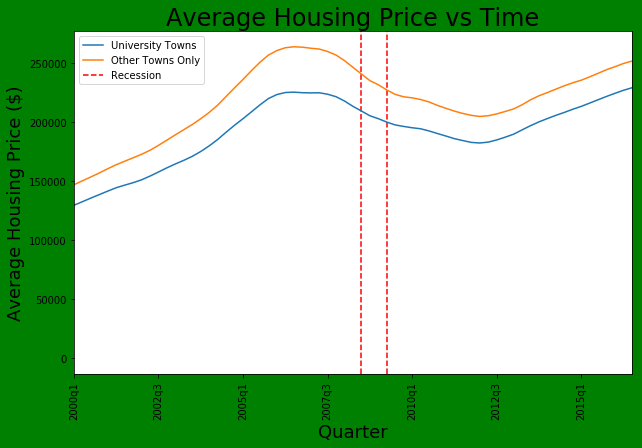

In [9]:
def plot_means(df1, df2):
    df1 = df1.mean(axis=0)
    df2 = df2.mean(axis=0)
    
    df1 = df1.drop('Ratio')
    df2 = df2.drop('Ratio')
    
    fig, ax = plt.subplots(facecolor='g', figsize=(10, 6.3))
    plt.xlabel("Quarter", fontsize=18)
    plt.ylabel("Average Housing Price ($)", fontsize=18)
    df1.plot(ax=ax)
    df2.plot(ax=ax)
    
    bottom = df1.keys().get_loc(get_recession_bottom())
    start = df1.keys().get_loc(get_recession_start())
    ax.vlines([start, bottom], 0, 1, transform=ax.get_xaxis_transform(), colors='r', label='recession', linestyle = '--')
    ax.legend(['University Towns', 'Other Towns Only', 'Recession'])
   
    plt.xticks(rotation=90)
    plt.title("Average Housing Price vs Time", fontsize=24)
# #     for label in ax.get_xaxis().get_ticklabels()[::2]:
#         label.set_visible(False)
    

def run_ttest():
    '''First creates new data showing the decline or growth of housing prices
    between the recession start and the recession bottom. Then runs a ttest
    comparing the university town values to the non-university towns values, 
    return whether the alternative hypothesis (that the two groups are the same)
    is true or not as well as the p-value of the confidence. 
    
    Return the tuple (different, p, better) where different=True if the t-test is
    True at a p<0.01 (we reject the null hypothesis), or different=False if 
    otherwise (we cannot reject the null hypothesis). The variable p should
    be equal to the exact p value returned from scipy.stats.ttest_ind(). The
    value for better should be either "university town" or "non-university town"
    depending on which has a lower mean price ratio (which is equivilent to a
    reduced market loss).'''
    

    df_housing = convert_housing_data_to_quarters()
    # Examining the declining section of the recession from the start to the bottom. The rising section is ignored.
    bottom = get_recession_bottom()
    start = get_recession_start()
    df_housing = df_housing.loc[:, :]
    df_housing['Ratio'] = df_housing['2008q3'] / df_housing['2009q2']
    
    df_university = get_list_of_university_towns()
    town_tuples = [tuple(x) for x in df_university.values]
    
    # Seperate housing dataframe into two: housing in uni towns, housing outside uni towns.
    df_uni_housing = df_housing[df_housing.index.isin(town_tuples)]
    df_other_housing = df_housing[~df_housing.index.isin(town_tuples)]
    plot_means(df_uni_housing.dropna().drop('Ratio'), df_other_housing.dropna().drop('Ratio'))
    # Conduct ttest, and analyze result
    test = stats.ttest_ind(df_uni_housing['Ratio'].dropna(), df_other_housing['Ratio'].dropna())
    p = test[1]
    #If pvalue is high enough, null hypothesis = True, ttest has concluded no significant difference
    different = (p < 0.01)
    
    # Compare the mean ratio of both dfs
    uni_ratio = df_uni_housing['Ratio'].mean()
    other_ratio = df_other_housing['Ratio'].mean()
    if uni_ratio < other_ratio:
        better = "university town"
    else:
        better = "non-university town"
    
    return (different, p, better)

run_ttest()